In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from xgboost import XGBClassifier
from sklearn import svm
import time
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, f1_score, make_scorer
import shap
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from tableone import TableOne, load_dataset
import pickle

In [13]:
np.random.seed(42)
'''
The first cell in this script generates the final feature sets,
you just need to choose either kmeans or gmm in the cluster_definition function call below.
The output files will be called train_df_kmeans or test_df_kmeans, or gmm if you choose that.

The latter cells run the ML models (RF, SVM, XGB) along with shap importance
'''

def cluster_definition(cluster_method,k): #Choose method, and K for Kmeans
    if cluster_method == 'kmeans':
        cluster_train = f'Train {k}Kmeans.csv'
        cluster_test = f'Test {k}Kmeans.csv'
        cluster_mem = 'cluster_kmeans'
        cluster_method='kmeans'
    elif cluster_method == 'gmm':
        cluster_train = f'Train {k}GMM.csv'
        cluster_test = f'Test {k}GMM.csv'
        cluster_mem = 'cluster_ncomponents'
        cluster_method='gmm'
    return(cluster_train, cluster_test, cluster_mem, cluster_method, k)
cluster_train, cluster_test, cluster_mem, cluster_method, k = cluster_definition('kmeans',k=3)

#Feature set generation
covariates = ['BMI.0.0', 'Age_recr.0.0', 'Smoking_status.0.0', 'Sex.0.0']
clusters_df_train = pd.read_csv(f"../Clustering_temp/{cluster_train}")
blood_counts = list(clusters_df_train.columns[:-1])
clusters_df_train=clusters_df_train[cluster_mem]
clusters_df_test = pd.read_csv(f"../Clustering_temp/{cluster_test}")
clusters_df_test=clusters_df_test[cluster_mem]
lifestyle=["Mood_swings.0.0","Alc_drinker_status.0.0","C_reactive_protein.0.0","Traff_int_major_rd.0.0","housing_score"]

#Train Data generation
train_data = pd.read_csv("../matching/matched_df.csv")
X_train=train_data[covariates+blood_counts+lifestyle]
y_train = train_data['cancer']
X_train=pd.merge(X_train,clusters_df_train,left_index=True, right_index=True)

#Test Data generation
test_data = pd.read_csv("../imp_test/test_imputed_df.csv")
X_test=test_data[covariates+blood_counts+lifestyle]
y_test = test_data['cancer']
X_test=pd.merge(X_test,clusters_df_test,left_index=True, right_index=True)

#Standardization
sclr=StandardScaler()
X_cols = X_train.columns
# Specify elements to remove
elements_categorical = ['Smoking_status.0.0', 'Sex.0.0','Mood_swings.0.0','Alc_drinker_status.0.0',cluster_mem]
# Create a new list that excludes the specified elements
continuous_cols = [x for x in covariates+blood_counts+lifestyle if x not in elements_categorical]
X_train[continuous_cols] = sclr.fit_transform(X_train[continuous_cols])
X_train = pd.DataFrame(X_train, columns = X_cols)
X_test[continuous_cols] = sclr.transform(X_test[continuous_cols])
X_test = pd.DataFrame(X_test, columns = X_cols)
# One-hot encode the specified columns
X_train = pd.get_dummies(X_train, columns=elements_categorical, drop_first=True)
X_test = pd.get_dummies(X_test, columns=elements_categorical, drop_first=True)

#Ensuring all columns are present in both train and test sets
clusters = X_train.columns[-k:]
for cluster in clusters:
    if cluster not in X_test.columns:
        X_test[cluster]=0

X_test.rename(columns={'Sex.0.0_0.0': 'Sex.0.0_0','Sex.0.0_1.0':'Sex.0.0_1'}, inplace=True)

#Feature set generation
X_train.to_csv(f'train_df_{k}{cluster_method}.csv')
X_test.to_csv(f'test_df_{k}{cluster_method}.csv')


In [2]:
### GENERATING FEATURE SETS
covariates = ['BMI.0.0', 'Age_recr.0.0', 'Smoking_status.0.0_1', 'Smoking_status.0.0_2','Sex.0.0_1']
def feature_chooser(features, covariates=covariates, blood_counts=blood_counts, 
                    lifestyle=lifestyle, clusters=list(clusters), X_train=X_train, X_test=X_test):
    '''
    This function is used to define the feature set. Choose from:
    - covariates
    - blood counts (covariates + blood counts)
    - clustered (covariates + cluster chosen in at start of script)
    - complete (covariates + clusters + lifestyle factors)
    '''
    if features == 'covariates':
        columns = covariates
    elif features == 'blood counts':
        columns = covariates + blood_counts 
    elif features == 'clustered':
        columns = covariates + clusters
    elif features == 'complete':
        columns = list(set(X_train.columns) - set(blood_counts))
    X_train_subset = X_train[columns]
    X_test_subset = X_test[columns]
    return X_train_subset, X_test_subset
X_train_subset, X_test_subset = feature_chooser('complete')

#Resampling - use X_train_resampled and y_train_resampled if you want this
ros = SMOTE(random_state=42) #Set the number of cases you want specifically via argument 'sampling strategy'
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_subset, y_train)
class_counts = y_train_resampled.value_counts()
print(class_counts)

#BINARY VERSION - Combining Leukaemia and lymphoma into 1   
y_train_binary = y_train.replace({'lymphoma':'cancer','leukemia':'cancer'})
y_test_binary = y_test.replace({'lymphoma':'cancer','leukemia':'cancer'})
ros = SMOTE(random_state=42) #Set the number of cases you want specifically via argument 'sampling strategy'
X_train_binary_resampled, y_train_binary_resampled = ros.fit_resample(X_train_subset, y_train_binary)
class_counts = y_train_resampled.value_counts()
print(class_counts)
'''
if cluster_method=='kmeans':
    #High WBC cluster or not for 2 cluster 
    X_train_wbc = X_train_subset.copy()
    X_test_wbc = X_test_subset.copy()
    for i in range(1,6):
        X_train_wbc = X_train_wbc.drop(columns=f'cluster_kmeans_{i}')
        X_test_wbc = X_test_wbc.drop(columns=f'cluster_kmeans_{i}')
'''



leukemia    10657
lymphoma    10657
healthy     10657
Name: cancer, dtype: int64
leukemia    10657
lymphoma    10657
healthy     10657
Name: cancer, dtype: int64


"\nif cluster_method=='kmeans':\n    #High WBC cluster or not for 2 cluster \n    X_train_wbc = X_train_subset.copy()\n    X_test_wbc = X_test_subset.copy()\n    for i in range(1,6):\n        X_train_wbc = X_train_wbc.drop(columns=f'cluster_kmeans_{i}')\n        X_test_wbc = X_test_wbc.drop(columns=f'cluster_kmeans_{i}')\n"

Index(['cluster_kmeans_1', 'Alc_drinker_status.0.0_1', 'housing_score',
       'Smoking_status.0.0_1', 'Mood_swings.0.0_1', 'Smoking_status.0.0_2',
       'Age_recr.0.0', 'Sex.0.0_1', 'Traff_int_major_rd.0.0',
       'Alc_drinker_status.0.0_2', 'BMI.0.0', 'C_reactive_protein.0.0',
       'cluster_kmeans_2'],
      dtype='object')
Index(['cluster_kmeans_1', 'Alc_drinker_status.0.0_1', 'housing_score',
       'Smoking_status.0.0_1', 'Mood_swings.0.0_1', 'Smoking_status.0.0_2',
       'Age_recr.0.0', 'Sex.0.0_1', 'Traff_int_major_rd.0.0',
       'Alc_drinker_status.0.0_2', 'BMI.0.0', 'C_reactive_protein.0.0',
       'cluster_kmeans_2'],
      dtype='object')
╒═══════════════════════════════════════════════════╤════╤═══════════╤═════════════════════╤═════════════════════╤═════════════════════╤═══════════╕
│                                                   │    │ Missing   │ Overall             │ cancer              │ healthy             │ P-Value   │
╞═════════════════════════════════════

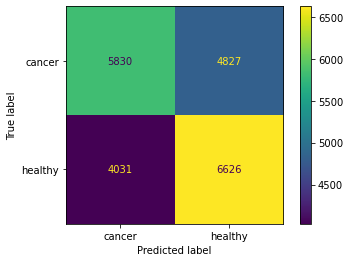

['cancer' 'cancer' 'cancer' ... 'cancer' 'cancer' 'healthy'] Set Results:
              precision    recall  f1-score   support

      cancer       0.12      0.81      0.21       983
     healthy       0.97      0.50      0.66     11355

    accuracy                           0.52     12338
   macro avg       0.55      0.66      0.44     12338
weighted avg       0.90      0.52      0.62     12338

AUC: 0.7511128192930188


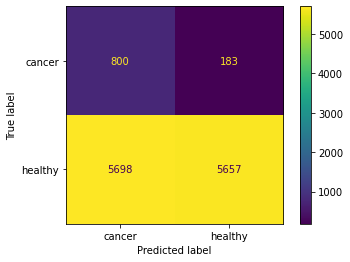

163.16435742378235 seconds or 2.719405957063039 mins or 0.04532343261771732 hrs


In [3]:
# ML model function
xgb=XGBClassifier()
rf=RandomForestClassifier(random_state=42)
svm_model=svm.SVC()


def model_test_main(model,x_train,y_train,x_test,y_test, table_one_only=False):
    '''
    Main ML model
    '''
    start_time = time.time()

    #Describing Features
    print(x_train.columns)
    print(x_test.columns)
    full_train=x_train.copy()
    full_train = pd.concat([x_train, y_train], axis=1)
    binary_cols = full_train.select_dtypes(include='bool').columns.tolist() + full_train.select_dtypes(include='uint8').columns.tolist()
    full_train[continuous_cols]=train_data[continuous_cols]
    mytable = TableOne(full_train, groupby='cancer',categorical = binary_cols, pval=True, nonnormal=blood_counts)
    print(mytable.tabulate(tablefmt = "fancy_grid"))
    if table_one_only == True:
        return
    #Hyperparameter dictionaries
    if model == xgb:
        param_grid={'n_estimators'     : np.array([50, 100, 500]),
                    'learning_rate'    : np.array([1e-2, 1e-1, 1]),
                    'max_depth'        : np.array([5, 8, 10])}
        #Encoding labels for xgb compatability
        encoder = LabelEncoder()
        print(y_train)
        y_train = encoder.fit_transform(y_train)
        print(y_train)
    elif model == rf:
        param_grid={'n_estimators'   : np.array([20, 30, 40, 50]),
                    'min_samples_leaf'   : np.array([1, 2, 5]),
                    'max_features' : np.array(['auto','log2']),
                    'criterion' :['gini', 'entropy'],
                    'max_depth':range(2,4,6),
                    'min_samples_split': np.array([2,3, 5, 10])}
    elif model == svm_model:
        param_grid={'C':[2^(0), 2^(1), 2^(2)],
                    'kernel':['poly','rbf']}
    inner=KFold(n_splits=5,shuffle=True,random_state=0)
    #Inner CV for hyperparameter tuning
    f1 = make_scorer(f1_score , average='macro')
    search_results=GridSearchCV(model,param_grid,cv=inner,n_jobs=-1, scoring=f1,return_train_score = True).fit(x_train,y_train)
    #Selecting optimal hyperparameters
    optimal_params=search_results.best_params_
    print(optimal_params)
    #Re-instantiating models with optimal hyperparameters
    if model==xgb:
        model=XGBClassifier(**optimal_params)
    elif model == rf:
        model =RandomForestClassifier(**optimal_params, random_state=42)    
    elif model==svm_model:
        model=svm.SVC(**optimal_params)
    #Fitting model with optimised parameters to training data
    model.fit(x_train,y_train)

    #Predicting using fitted model on train set
    y_pred_train = model.predict(x_train)
    #Predicting using fitted model on test set
    y_pred_test = model.predict(x_test)

    #Get results for train and test sets
    for predictions, observations, features in zip([y_pred_train, y_pred_test],[y_train, y_test],[x_train,x_test]):
        #De-encoding labels for xgb
        if isinstance(model,XGBClassifier):
            predictions = encoder.inverse_transform(predictions)
        #Results Visualisation
        print(f'{predictions} Set Results:')
        print(classification_report(observations,predictions))
        if 'cancer' in predictions:
            print(f"AUC: {roc_auc_score(observations, model.predict_proba(features)[:,1])}")
        else:
            print(f"AUC: {roc_auc_score(observations, model.predict_proba(features), multi_class='ovr')}")
        cmatrix=ConfusionMatrixDisplay.from_predictions(observations, predictions)
        plt.show(cmatrix)
    time_taken=(time.time() - start_time)
    print(f'{time_taken} seconds or {time_taken/60} mins or {time_taken/(60*60)} hrs')
    return(model, y_pred_test)


model, y_pred_test=model_test_main(rf, X_train_binary_resampled, y_train_binary_resampled, X_test_subset, y_test_binary, table_one_only=False)

In [5]:
#Saving model and predictions
if 'cancer' in model.classes_: 
    pickle.dump(model, open('rf_model_binary.sav', 'wb'))

    # Create a pandas DataFrame with the two arrays as columns
    df = pd.DataFrame({"Observations": y_test_binary, "Predictions": y_pred_test})
    # Save the DataFrame to a CSV file
    df.to_csv("Predictions_binary.csv", index=False)
else:
    pickle.dump(model, open('rf_model_multi.sav', 'wb'))

    # Create a pandas DataFrame with the two arrays as columns
    df = pd.DataFrame({"Observations": y_test, "Predictions": y_pred_test})
    # Save the DataFrame to a CSV file
    df.to_csv("Predictions_multi.csv", index=False)


# feature importance using tree impurity
features = X_test_subset.columns
print(features)
print(model)
importances = model.feature_importances_
print(importances)
indices = np.argsort(importances)
print(indices)


Index(['cluster_kmeans_1', 'Alc_drinker_status.0.0_1', 'housing_score',
       'Smoking_status.0.0_1', 'Mood_swings.0.0_1', 'Smoking_status.0.0_2',
       'Age_recr.0.0', 'Sex.0.0_1', 'Traff_int_major_rd.0.0',
       'Alc_drinker_status.0.0_2', 'BMI.0.0', 'C_reactive_protein.0.0',
       'cluster_kmeans_2'],
      dtype='object')
RandomForestClassifier(criterion='entropy', max_depth=2, n_estimators=30,
                       random_state=42)
[0.0137381  0.00248674 0.175366   0.00048103 0.13464609 0.00834694
 0.3745371  0.01856151 0.05062254 0.06294125 0.00977085 0.13978538
 0.00871647]
[ 3  1  5 12 10  0  7  8  9  4 11  2  6]


`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


['cancer' 'healthy']


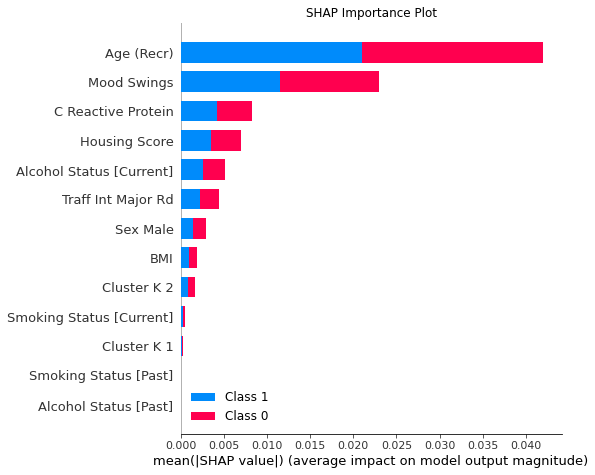

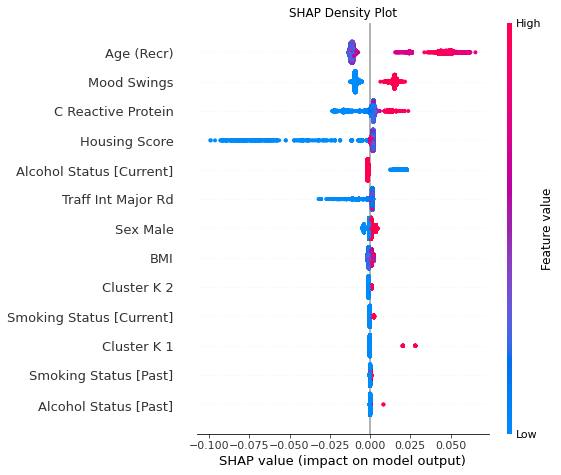

In [12]:
#SHAP =================================================================================================
#Change feature names to be interpretable
feature_names = ['Cluster K 1','Alcohol Status [Past]', 'Housing Score', 'Smoking Status [Past]', 'Mood Swings','Smoking Status [Current]', 'Age (Recr)', 'Sex Male', 
                 'Traff Int Major Rd', 'Alcohol Status [Current]', 'BMI', 'C Reactive Protein', 'Cluster K 2']

#Select SHAP kernel based on ML model type
if (isinstance(model,RandomForestClassifier))|(isinstance(model,XGBClassifier)):
    explainer = shap.TreeExplainer(model)
elif isinstance(model,svm.SVC):
    explainer = shap.KernelExplainer(model)

#Generate shap values
shap_values = explainer.shap_values(X_test_subset)
print(model.classes_)

if 'cancer' in model.classes_: 
    #SHAP plots for BINARY
    plt.title('SHAP Importance Plot')
    shap.summary_plot(shap_values, features = X_test_subset, feature_names = feature_names)
    plt.show()

    plt.title('SHAP Density Plot')
    shap.summary_plot(shap_values[0], features = X_test_subset, feature_names = feature_names)
    plt.show()
else:
    #SHAP plots for each MULTI-CLASS
    plt.title('SHAP Importance Plot for Healthy Prediciton')
    shap.summary_plot(shap_values, features = X_test_subset, class_inds = [0])
    plt.show()

    plt.title('SHAP Density Plot for Healthy Prediction')
    shap.summary_plot(shap_values[0], features = X_test_subset)
    plt.show()

    plt.title('SHAP Importance Plot for Leukaemia Prediciton')
    shap.summary_plot(shap_values, features = X_test_subset, class_inds = [1])
    plt.show()

    plt.title('SHAP Density Plot for Leukaemia Prediction')
    shap.summary_plot(shap_values[1], features = X_test_subset)
    plt.show()

    plt.title('SHAP Importance Plot for Lymphoma Prediciton')
    shap.summary_plot(shap_values, features = X_test_subset, class_inds = [2])
    plt.show()

    plt.title('SHAP Density Plot for Lymphoma Prediction')
    shap.summary_plot(shap_values[2], features = X_test_subset)
    plt.show()

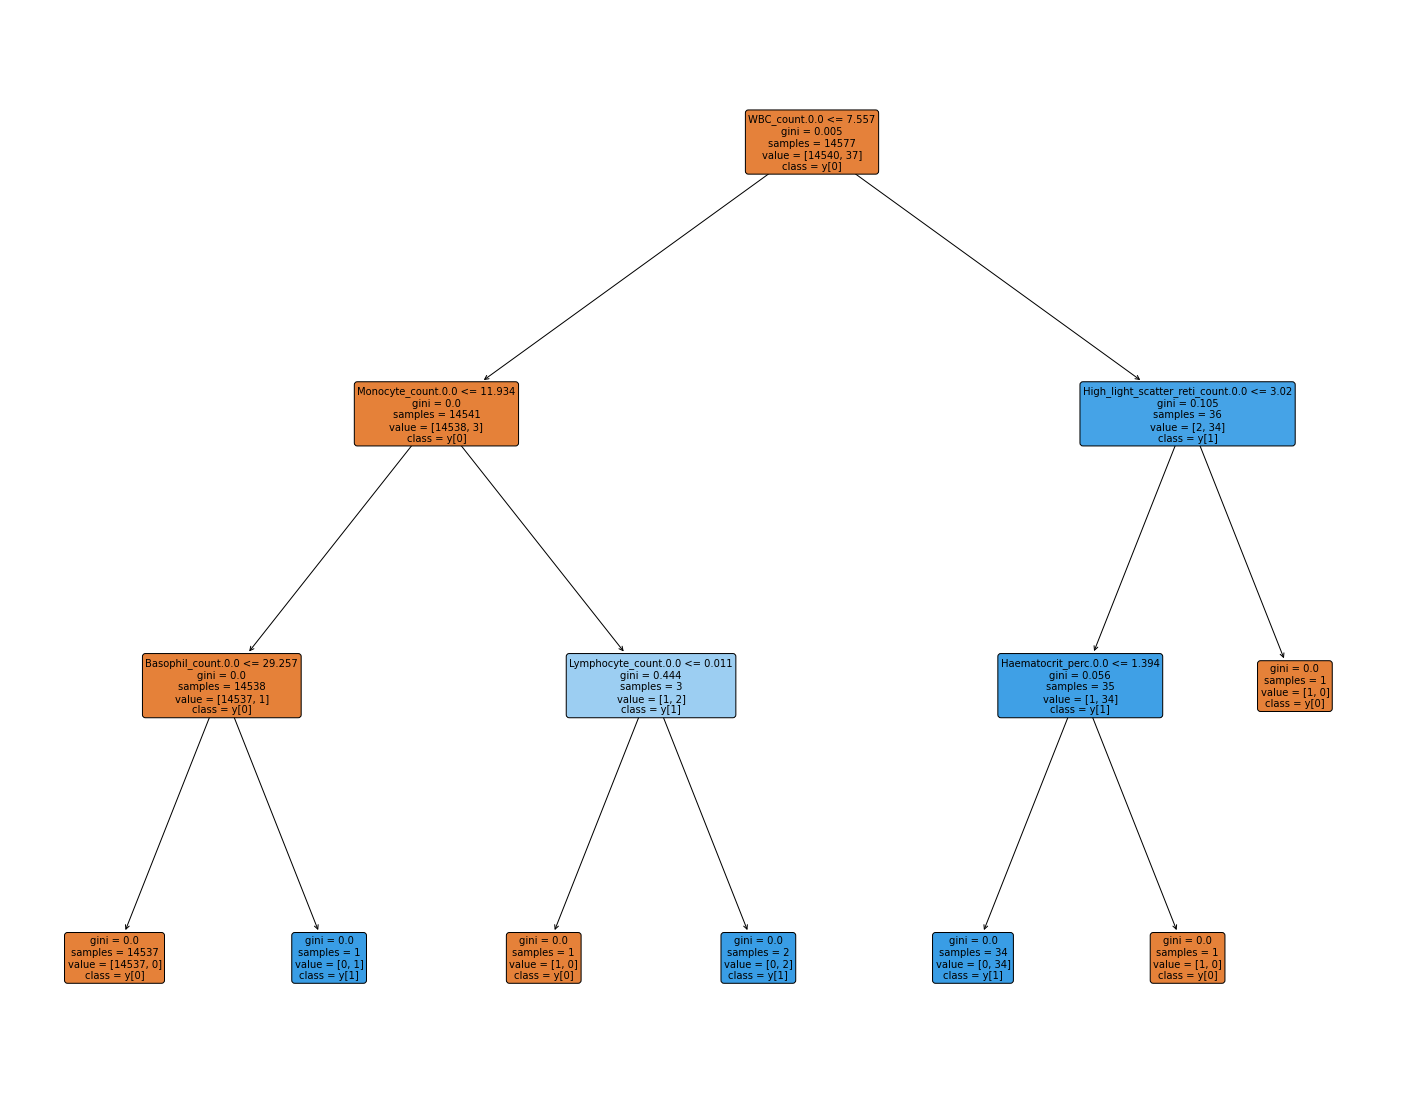

In [23]:
#DECISION TREE =================================================================================================
from sklearn.tree import DecisionTreeClassifier, plot_tree
import graphviz

# Define predictors and target variable
X_tree = X_train[['Lymphocyte_count.0.0', 'Monocyte_count.0.0', 'Reti_count.0.0', 'WBC_count.0.0', 'RBC_count.0.0', 
                        'Hgb_conc.0.0', 'Haematocrit_perc.0.0', 'Platelet_count.0.0', 'Basophil_count.0.0', 'Eosinophil_count.0.0', 
                        'Neutrophil_count.0.0','Immature_ret_fraction.0.0', 'High_light_scatter_reti_count.0.0']]
y_tree = X_train['cluster_kmeans_1']

# Create a decision tree classifier
clf = DecisionTreeClassifier(max_depth=3, random_state=42)

# Fit the model
clf.fit(X_tree, y_tree)

# Visualize the decision tree
plt.figure(figsize=(25,20))
plot_tree(clf, feature_names=X_tree.columns, class_names=True, filled=True, rounded=True)
plt.show()